AI/ML directed high-throughput virtual screening of probes

Siva Dasetty, Max Topel | Ferguson Lab

Standard imports

In [5]:
import os
import os.path
import sys
import importlib
import yaml

import subprocess

from time import time
from datetime import datetime

import numpy as np
import pandas as pd
import math

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Descriptors
from rdkit.Chem.Fragments import *

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib  import cm
from PIL import Image
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import multiprocessing

from sklearn.metrics import mean_squared_error

sys.path.append("../Codes/")


import utils_activeLearning_Oliver as ut

import utils_functions as utils_functions
#import utils_figures as utils_figures

importlib.reload(ut)
importlib.reload(utils_functions)
#importlib.reload(utils_figures)

import selfies as sf

from oliver_vae.VAE import VAE_encode, VAE_decode

import torch
from torch import nn

import copy

Plot settings

In [4]:
plt.rcParams.update({'font.size': 20})

# time stamp
now = datetime.now()
now = str(now)[:10]
#figures_dir = './Figures/{}'.format(str(now)).replace(':','-')

Read all search molecules

In [3]:
# read all potential linear probes

all_potential_linear_probes = pd.read_csv('../Data/VAE_data/SMILES_linearProbes_All.csv')

# convert to list
all_potential_linear_probesList = all_potential_linear_probes.smiles

## get molecular weight and other properties using smiles

In [4]:
molWts = []
ccount = []
fcount = []
clcount = []
brcount = []
for i in range(all_potential_linear_probes.smiles.values.shape[0]):
    molWts.append(Descriptors.ExactMolWt(Chem.MolFromSmiles(all_potential_linear_probes.smiles.values[i])))
    ccount.append(all_potential_linear_probes.smiles.values[i].count('C') - all_potential_linear_probes.smiles.values[i].count('Cl'))
    fcount.append(all_potential_linear_probes.smiles.values[i].count('F'))
    clcount.append(all_potential_linear_probes.smiles.values[i].count('Cl'))
    brcount.append(all_potential_linear_probes.smiles.values[i].count('Br'))
    
##smiles_latentspace
molWtsArray = np.array(molWts)
all_potential_linear_probes['molwt'] = molWtsArray
all_potential_linear_probes['ccount'] = np.array(ccount)
all_potential_linear_probes['fcount'] = np.array(fcount)
all_potential_linear_probes['clcount'] = np.array(clcount)
all_potential_linear_probes['brcount'] = np.array(brcount)


# save updated dataframe [if running first time]
#all_potential_linear_probes.to_csv('../Data/VAE_data/SMILES_linearProbes_All_Properties.csv')

# read updated dataframe

all_potential_linear_probes = pd.read_csv("../Data/VAE_data/SMILES_linearProbes_All_Properties.csv")

#all_potential_linear_probes

Get SELFIE reprsentation of all molecules for passing to trained VAE

In [8]:
# Encode molecules using Oliver's encoder

print('Representation: SMILES')


# all search probes
selfies_list, selfies_alphabet, largest_selfies_len, encoding_list, encoding_alphabet, largest_molecule_len = ut.get_selfie_and_smiles_encodings_for_dataset(all_potential_linear_probes)

# completed probes
#selfies_list, selfies_alphabet, largest_selfies_len, encoding_list, encoding_alphabet, largest_molecule_len = ut.get_selfie_and_smiles_encodings_for_dataset(pfosfldataCopy)

# unexplored linear probes
#selfies_list, selfies_alphabet, largest_selfies_len, encoding_list, encoding_alphabet, largest_molecule_len = ut.get_selfie_and_smiles_encodings_for_dataset(unexplored_probes_list_df)

# mobo probes
#selfies_list, selfies_alphabet, largest_selfies_len, encoding_list, encoding_alphabet, largest_molecule_len = ut.get_selfie_and_smiles_encodings_for_dataset(mobo_candidates)

#selfies_list, selfies_alphabet, largest_selfies_len, encoding_list, encoding_alphabet, largest_molecule_len = ut.get_selfie_and_smiles_encodings_for_dataset(mobo_candidates_batch2)

print('--> Creating one-hot encoding...')
# set largest selfies len according to Oliver data
largest_selfies_len = 137
onehotdata = ut.multiple_selfies_to_hot(selfies_list, largest_selfies_len, selfies_alphabet)
        
print('Finished creating one-hot encoding.')

print("Length of largest molecule: ", largest_molecule_len)
print("Encoding alphabets: ", encoding_alphabet)
#print("Encoding list: ", encoding_list)

#print("selfies list: ", selfies_list)
print("selfies alphabet: ", selfies_alphabet)
print("Length of largest selfies: ", largest_selfies_len)

Representation: SMILES
--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
--> Creating one-hot encoding...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3850/3850 [00:01<00:00, 2126.66it/s]


Finished creating one-hot encoding.
Length of largest molecule:  130
Encoding alphabets:  [')', '+', '[', 'C', ']', 'B', 'N', 'l', 'P', 'r', 'F', '(', ' ']
selfies alphabet:  ['[epsilon]', '[C]', '[=C]', '[C@Hexpl]', '[N]', '[Ring1]', '[Branch1_1]', '[C@@Hexpl]', '[Branch1_3]', '[=O]', '[O]', '[Branch2_3]', '[Branch2_1]', '[=N]', '[c]', '[F]', '[Ring2]', '[Branch1_2]', '[o]', '[n]', '[S]', '[Branch2_2]', '[#N]', '[#C]', '[=S]', '[s]', '[-c]', '[Cl]', '[=c]', '[/C]', '[/c]', '[Br]', '[-n]', '[nHexpl]', '[=N+expl]', '[O-expl]', '[N+expl]', '[C@expl]', '[C@@expl]', '[/N]', '[\\S]', '[\\c]', '[.]', '[n+expl]', '[/O]', '[Expl-Ring1]', '[\\C]', '[P]', '[/S]', '[\\N]', '[\\O]', '[I]', '[Siexpl]', '[S@@expl]', '[S@expl]']
Length of largest selfies:  137


Set device

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Read trained VAE model

In [10]:
# Load Oliver's model 

# Oliver VAE hyperparameters or settings

if os.path.exists("OliverVAE-settings.yml"):
    settings = yaml.safe_load(open("OliverVAE-settings.yml", "r"))
else:
    print("Expected a file settings.yml but didn't find it.")

print('--> Acquiring data...')

len_max_molec = 137 #onehotdata.shape[1]
len_alphabet = 55 #onehotdata.shape[2]
len_max_molec1Hot = len_max_molec * len_alphabet

encoder_parameter = settings['encoder']
decoder_parameter = settings['decoder']
training_parameters = settings['training']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('-->' + str(device))

model_encode = VAE_encode(len_max_molec1Hot, **encoder_parameter).to(device)
model_decode = VAE_decode(len_alphabet, **decoder_parameter).to(device)

# load model
model_dir='oliver_vae/Models/2021-08-05 12-14-37/'
warm_path = model_dir #'./Models/2020-09-04 15-15-46'
warm_epoch = 1999
warm_model = os.path.join(warm_path, 'Epochs-' + str(warm_epoch))

encoder_state = torch.load(os.path.join(warm_model, 'encode.tar'))
decoder_state = torch.load(os.path.join(warm_model, 'decode.tar'))

model_encode.load_state_dict(encoder_state['state_dict'])
model_decode.load_state_dict(decoder_state['state_dict'])

model_encode.to(device)
model_decode.to(device)

--> Acquiring data...
-->cuda


VAE_decode(
  (decode_RNN): GRU(100, 200, num_layers=3)
  (decode_FC): Sequential(
    (0): Linear(in_features=200, out_features=55, bias=True)
  )
)

Encode all search molecules using VAE and the SELFIE representation

In [11]:
# flatten one hot data
inp_flat_one_hot =  torch.tensor(np.array(onehotdata), dtype=torch.float).clone().detach().to(device).flatten(start_dim=1)

print(inp_flat_one_hot.shape)

total_correct = 0
all_correct_molecules = set()
all_incorrect_molecules = set()

encoded_list = [] #torch.zeros(inp_flat_one_hot.shape[0]).to(device)
mean_encoded_list = []
# encode and decode each probe 
for i in range(inp_flat_one_hot.shape[0]):

    # encode and save to encoded list
    fancy_latent_point, mus, log_vars = model_encode(inp_flat_one_hot[i].unsqueeze(0))
    
    # append encoded probe to encoded_list 
    #encoded_list.append(fancy_latent_point[0])
    encoded_list.append(mus[0])
    
    mean_encoded_list.append(mus[0])
    
    
    # decode the probe
    fancy_latent_point = fancy_latent_point.unsqueeze(0)

    # initialize hidden
    hidden = model_decode.init_hidden()
    #  runs over letters from molecules (len=size of largest molecule)
    gathered_atoms = []
    for _ in range(len_max_molec):
        out_one_hot, hidden = model_decode(fancy_latent_point, hidden)

        out_one_hot = out_one_hot.flatten().detach()
        soft = nn.Softmax(0)
        out_one_hot = soft(out_one_hot)
        out_index = out_one_hot.argmax(0)
        gathered_atoms.append(out_index.data.cpu().tolist())
    #print("gathered atoms")
    #print(gathered_atoms)
    molecule_pre = ''
    for i in gathered_atoms:
        molecule_pre += selfies_alphabet[i]
    molecule = molecule_pre.replace(' ', '')
    #print("molecule", sf.decoder(molecule))
    
    molecule = sf.decoder(molecule)
    if ut.is_correct_smiles(molecule):
        #print("correct")
        total_correct += 1
        all_correct_molecules.add(molecule)         
    else:
        all_incorrect_molecules.add(molecule)         
        #print("incorrect molecule", molecule)

# Convert encoded list to Torch tensor
encoded_torch = torch.stack(encoded_list)
mean_encoded_torch = torch.stack(mean_encoded_list)

encoded_array = encoded_torch.cpu().detach().numpy()
mean_encoded_array = mean_encoded_torch.cpu().detach().numpy()    
    
print("% correct: ", 100*(total_correct)/1000)

#onehotdata.shape

torch.Size([3850, 7535])
% correct:  0.0


Save/read encoded data of all search molecules

In [12]:
np.save('../Data/VAE_data/LatentVecs_AllSearchLinearProbes.npy', encoded_array)

In [13]:
all_search_linear_probes_array = np.load('../Data/VAE_data/LatentVecs_AllSearchLinearProbes.npy')

Read latent space points of ZINC training set

In [6]:
# Load Oliver's training data in latent space to perform latent space quality checks

latentspace_extensive = np.load('../Data/VAE_data/LatentVecs_Extensive.npy')
latentspace_primary = np.load('../Data/VAE_data/LatentVecs_Primary.npy')
latentspace_ZINC = np.load('../Data/VAE_data/LatentVecs_ZINC.npy')

# total latent space data
latentspace_training = np.concatenate((latentspace_extensive, latentspace_primary, latentspace_ZINC), axis=0)

# Load the corresponding SMILES labels

smiles_extensive = pd.read_csv("../Data/VAE_data/Ext_Lib.csv")
smiles_primary = pd.read_csv("../Data/VAE_data/PS_Lib.csv")
smiles_ZINC = pd.read_csv("../Data/VAE_data/ZINC_Lib.csv")

#smiles_latentspace
latentspace_smiles = pd.concat([smiles_extensive, smiles_primary, smiles_ZINC])

Space for calculating properties of molecules in ZINC set, if required

Apply PCA over search set

[89.58982  91.56334  92.90315  94.01864  94.92091  95.50037  96.03267
 96.5355   96.86376  97.1596   97.41349  97.65239  97.86564  98.05541
 98.21808  98.37208  98.51624  98.64283  98.76724  98.87211  98.97498
 99.06517  99.149445 99.222305 99.291756 99.358116 99.41777  99.47132
 99.51957  99.56569  99.606476 99.642334 99.67528  99.70566  99.73209
 99.75523  99.77686  99.79739  99.814415 99.83     99.84519  99.85845
 99.87122  99.883316 99.89443  99.90424  99.913704 99.922714 99.93131
 99.93866  99.945496 99.95228  99.95833  99.96304  99.96756  99.9719
 99.97585  99.97932  99.9827   99.985725 99.98837  99.990875 99.993
 99.994354 99.99535  99.996216 99.997025 99.99767  99.998276 99.998825
 99.99927  99.99952  99.99974  99.999855 99.999954 99.99997  99.99997
 99.99997  99.99997  99.99997  99.99997  99.99997  99.99997  99.99997
 99.99997  99.99997  99.99997  99.99997  99.99997  99.99997  99.99997
 99.99997  99.99997  99.99997  99.99997  99.99997  99.99997  99.99997
 99.99997  99.99997 ]


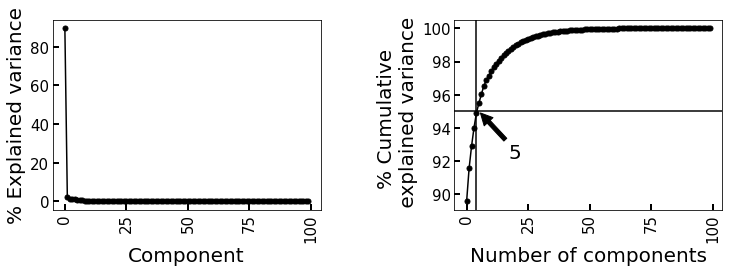

In [26]:
# Perform PCA on the total encoded data including probes

pca = PCA() #n_components=2
pca.fit(all_search_linear_probes_array) 


fig = plt.figure(figsize=[12,3])
fig.tight_layout(pad=10.0)
fig.subplots_adjust(bottom=0.0, hspace=.5, wspace=.5)

ax = []
for a in range(2):
    ax.append('ax' + str(a)) 
    ax[a] = fig.add_subplot(1, 2, a+1)
    ax[a].tick_params(axis="x", labelsize=15, direction='in', length=6, width=2, colors='black', rotation=90)
    ax[a].tick_params(axis="y", labelsize=15, direction='in', length=6, width=2, colors='black')
    ax[a].tick_params(which='minor', direction='in', length=3, width=2)  


#print("Explained variance: ", 100*pca2.explained_variance_ratio_)

ax[0].plot(100*pca.explained_variance_ratio_, color='black', marker='.', ms=10)
ax[0].set_xlabel('Component', fontsize=20)
ax[0].set_ylabel('% Explained variance', fontsize=20)

ax[1].plot(np.cumsum(100*pca.explained_variance_ratio_), color='black', marker='.', ms=10)

ax[1].set_xlabel('Number of components', fontsize=20)
ax[1].set_ylabel('% Cumulative \n explained variance', fontsize=20)
ax[1].axhline(y=95, color='black')
ax[1].axvline(x=4, color='black')

ax[1].annotate('5', (5, 95),
            xytext=(0.25, 0.25), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=20,
            horizontalalignment='right', verticalalignment='bottom')

print(np.cumsum(100*pca.explained_variance_ratio_))

plt.savefig(figures_dir + '-PCAVariance_total-zoom.png', bbox_inches = "tight")

#plt.savefig('../WeeklyAnalysis/Figures/PCAVariance_total-zoom.png', dpi=300, bbox_inches = "tight")

Transform latent points to PC space

In [27]:
## search set

projected_all_search_linear_probes_array = pca.transform(all_search_linear_probes_array) # search set
projected_zinc_set = pca.transform(latentspace_training) # ZINC set


## save the arrays (ONLY ONCE)

#np.save('../Data/VAE_data/PCA_AllSearchLinearProbes.npy', projected_all_search_linear_probes_array)
#np.save('../Data/VAE_data/PCA_ZINC_TrainingSet.npy', projected_zinc_set)




In [7]:
## read saved PCA arrays
projected_all_search_linear_probes_array = np.load('../Data/VAE_data/PCA_AllSearchLinearProbes.npy')

projected_zinc_set = np.load('../Data/VAE_data/PCA_ZINC_TrainingSet.npy')
